In [8]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Trainer, TrainingArguments
import torch
from PIL import Image
import torch.nn as nn
import cv2
from torchvision import transforms
from tqdm.notebook import tqdm
# from ultralytics import YOLO
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import requests
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import os
import pickle
import random

In [9]:
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

### Train

In [10]:
pip install transformers datasets torch torchvision -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install ultralytics -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.tasks import attempt_load_one_weight

In [13]:
import torch
import ultralytics
from ultralytics import YOLO

print(ultralytics.__version__)

# Load the YOLOv8 model
model_yolo = YOLO('yolov8n.pt')

# Access the backbone layers
backbone = model_yolo.model.model[:10]  # Layers 0 to 9 form the backbone

# Create a new Sequential model with just the backbone layers
backbone_model = torch.nn.Sequential(*backbone)

8.3.40


In [14]:
class FeatureExtractorModel(nn.Module):
    def __init__(self, backbone_model):
        super(FeatureExtractorModel, self).__init__()
        self.backbone_model = backbone_model
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def preprocess_image(self, image):
        tensor_image = self.preprocess(image).unsqueeze(0)  # Thêm batch dimension
        return tensor_image

    def forward(self, image):
        # Tiền xử lý ảnh
        image_tensor = self.preprocess_image(image)

        # Trích xuất đặc trưng với backbone model
        with torch.no_grad():
            features = self.backbone_model(image_tensor)
        
        # Kiểm tra và điều chỉnh kích thước đầu ra của features
        if features.shape[1] != 3 or features.shape[2:] != (224, 224):
            features = torch.nn.functional.interpolate(features, size=(224, 224), mode='bilinear', align_corners=False)
            features = features[:, :3, :, :]  # Chỉ giữ 3 kênh đầu

        return features

# Sử dụng FeatureExtractorModel để trích xuất đặc trưng từ ảnh
feature_extractor = FeatureExtractorModel(backbone_model)

## Generate

In [22]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/yolov8_gpt2_v20ep/pytorch/default/1'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)
    
# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path, show_image=False):
    response = requests.get(image_path)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
    pixel_values = feature_extractor(image_rgb)
    
    output_ids = model.generate(
                pixel_values
                ,max_length=150
                ,min_length=10
                ,early_stopping=True
            )
    print(output_ids.shape)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if show_image == True:
        plt.imshow(image_rgb)
    return caption

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [16]:
# Hàm tải ảnh từ URL
def load_image(image_url):
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb
# Hàm hiển thị ảnh và caption theo chiều dọc với kiểm tra từng ảnh
def display_images_vertical_layout_fixed(model, image_urls):
    total_images = len(image_urls)

    # Điều chỉnh kích thước từng hàng
    fig, axes = plt.subplots(total_images, 2, figsize=(8, 3 * total_images))  # Chiều cao giảm
    # fig.suptitle("Ảnh và Caption (Dọc)", fontsize=16, y=1.02)

    # Nếu chỉ có một ảnh, đảm bảo `axes` không phải là mảng
    if total_images == 1:
        axes = [axes]

    for i, image_url in enumerate(image_urls):
        try:
            # Tải ảnh và caption
            image_rgb = load_image(image_url)
            caption = predict_internet_caption(model, image_url)
            
            # Bên trái: hiển thị ảnh
            axes[i][0].imshow(image_rgb)
            axes[i][0].axis('off')  # Tắt viền
            
            # Bên phải: hiển thị caption
            axes[i][1].text(0.5, 0.5, caption, fontsize=12, ha='center', va='center', wrap=True)
            axes[i][1].axis('off')  # Tắt viền
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh tại index {i}: {e}")
            # Bỏ qua ảnh bị lỗi, giữ ô trống
            axes[i][0].axis('off')
            axes[i][1].axis('off')

    # Điều chỉnh khoảng cách giữa các hàng
    plt.subplots_adjust(hspace=0.1)  # Giảm hspace để các dòng gần hơn
    plt.tight_layout()
    output_path = "test_picture.png"  # Đường dẫn tệp PNG
    plt.savefig(output_path, format='png', dpi=300)
    plt.show()


torch.Size([1, 95])
torch.Size([1, 110])
torch.Size([1, 100])


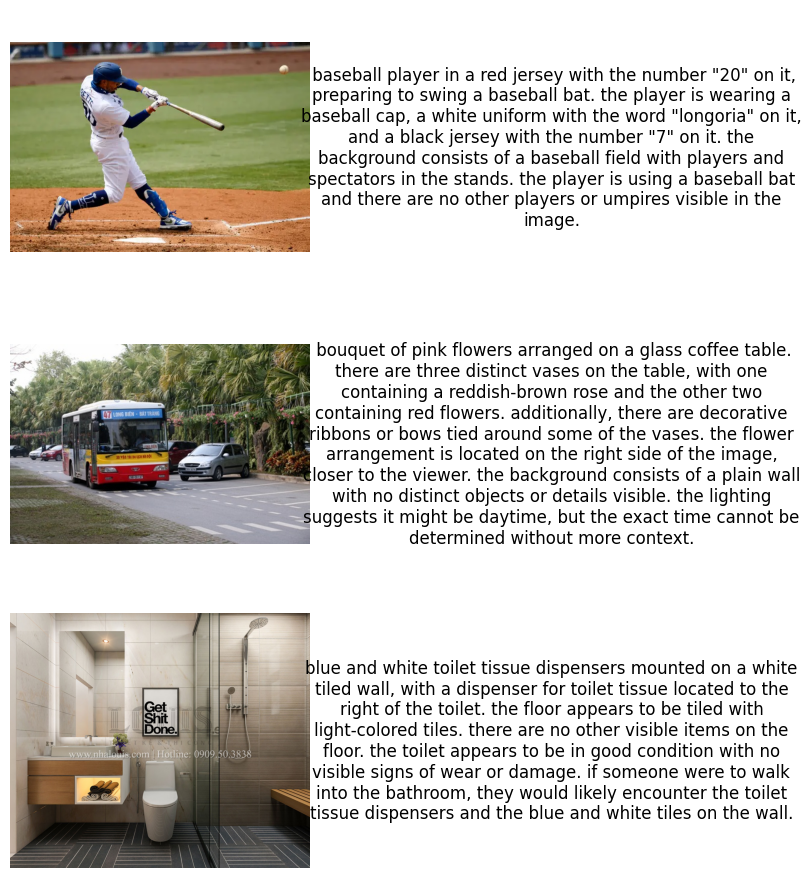

In [17]:
# Danh sách URL ảnh
image_urls = [
    "https://media.dolenglish.vn/PUBLIC/MEDIA/0f3179b4-23f7-4e0c-ad21-882339dd52ed.webp",
    "https://ecoparker.com/sites/default/files/di%20gi/xe-bus-hanoi-ecopark.jpg",
    "https://nhalouis.com/wp-content/uploads/2019/10/dien-tich-chuan-nha-ve-sinh.jpg",
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)


torch.Size([1, 97])
torch.Size([1, 139])
torch.Size([1, 132])


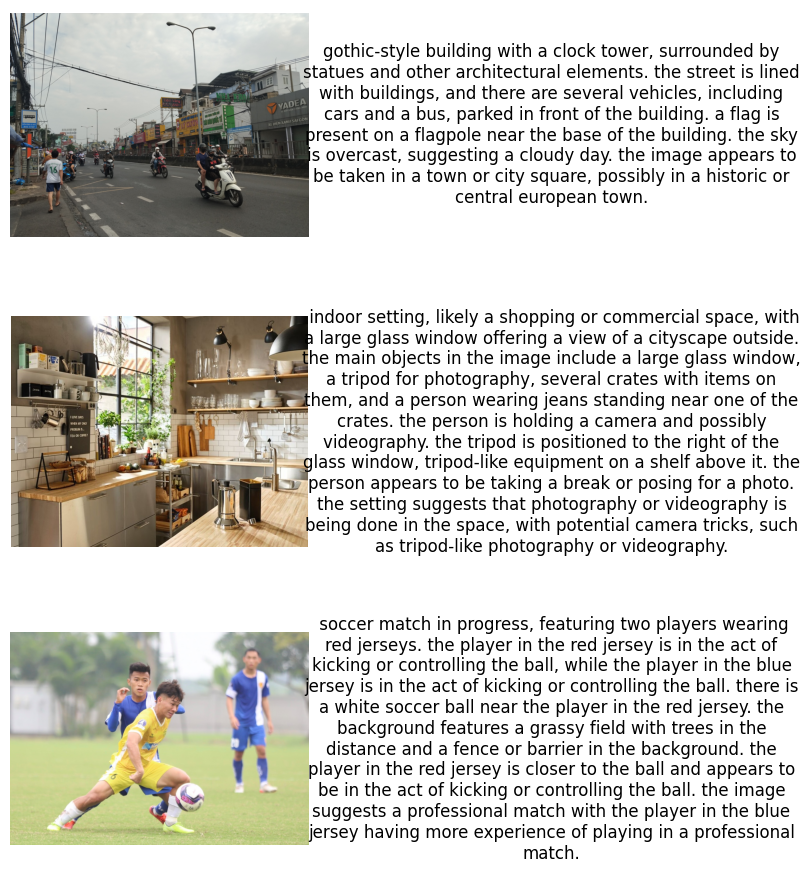

In [18]:
# Danh sách URL ảnh
image_urls = [
    "http://116.118.50.253:9000/mlflow/user_images/image_20241110014605.jpg",
    "https://cdn.nguyenkimmall.com/images/companies/_1/Content/tin-tuc/gia-dung/4-yeu-to-giup-ban-so-huu-mau-nha-bep-dep-tien-dung-h1.jpg",
    "https://thanhnien.mediacdn.vn/Uploaded/quangtuyen/2022_04_22/anh-5-1381.jpg",
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)

torch.Size([1, 103])
torch.Size([1, 72])
torch.Size([1, 86])
Lỗi khi xử lý ảnh tại index 3: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

torch.Size([1, 125])
torch.Size([1, 105])
torch.Size([1, 92])
torch.Size([1, 87])
torch.Size([1, 77])


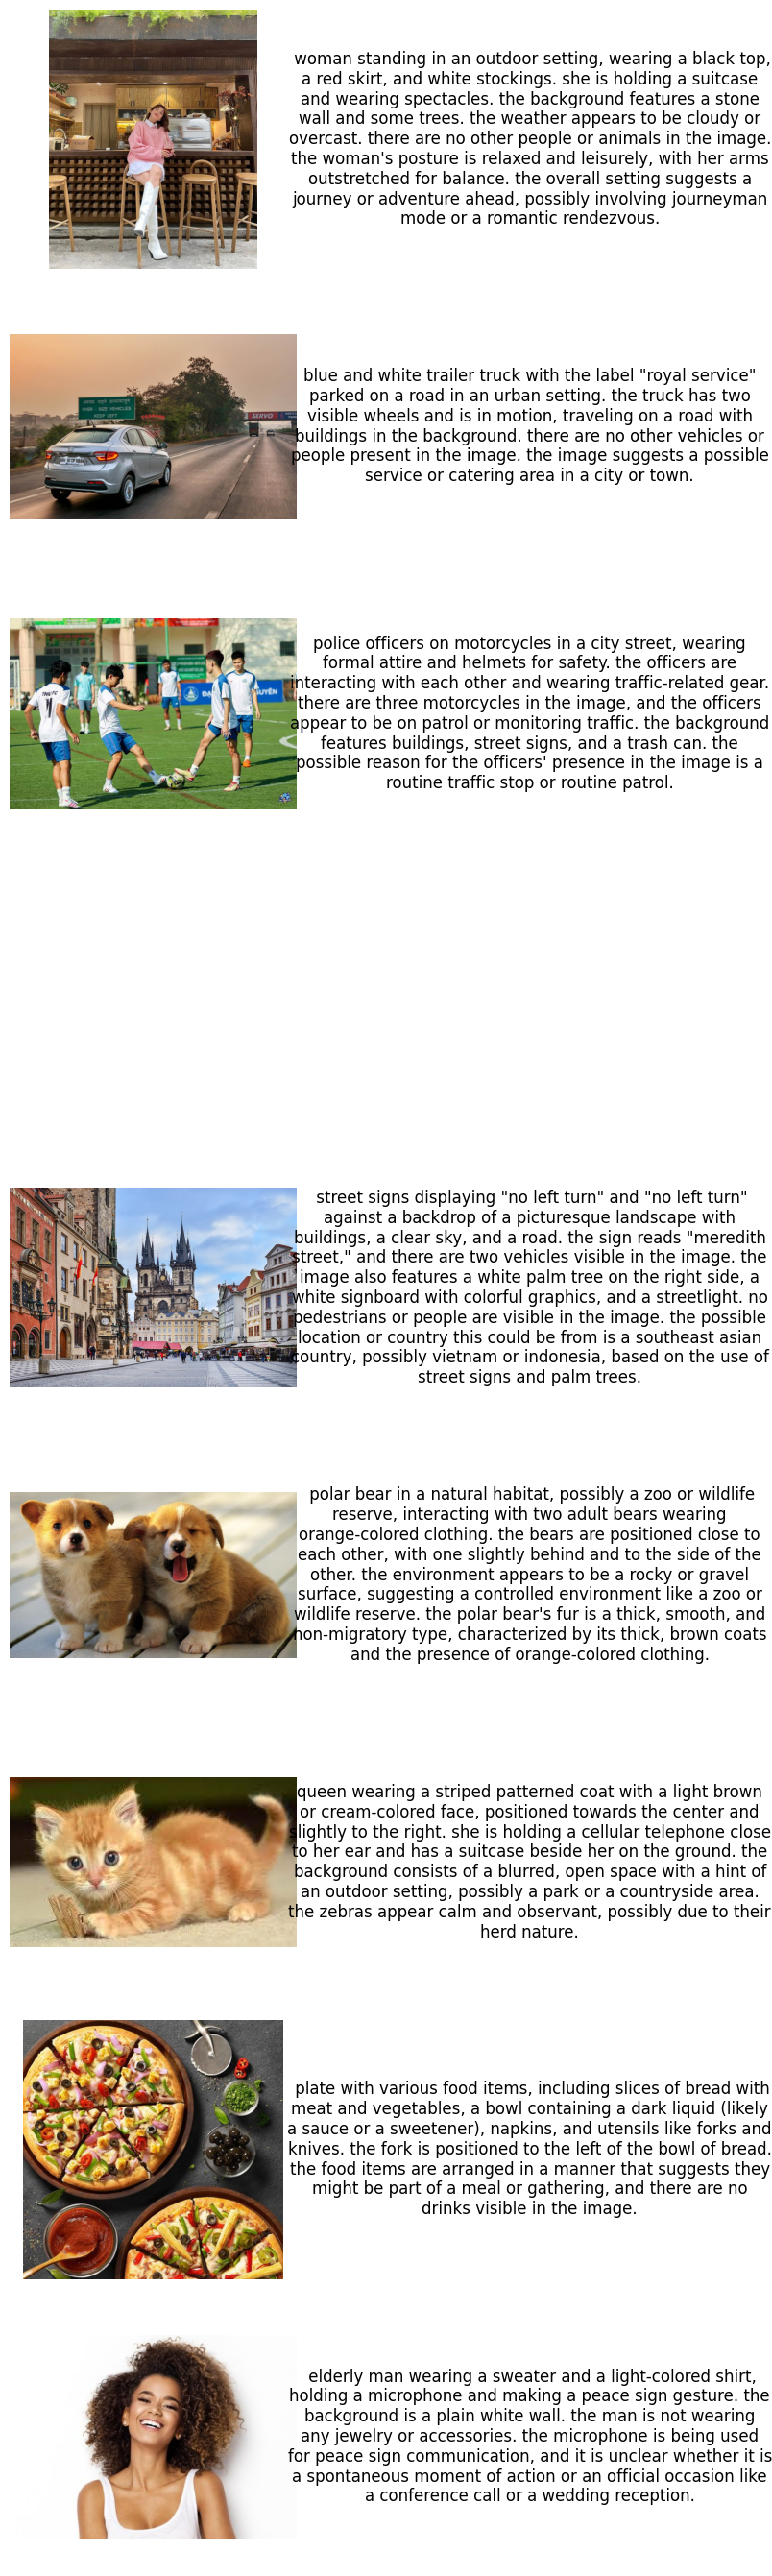

In [19]:
# Danh sách URL ảnh
image_urls = [
    "https://i0.wp.com/noithatanthinhphat.vn/wp-content/uploads/2022/08/tao-dang-chup-anh-o-quan-cafe-1-%40truonghoang.maianh.jpg?resize=700%2C875&ssl=1",
    "https://todocar.vn/public/upload/images/article/2021/01/Kinh-nghiem-can-duong-xac-dinh-vi-tri-xe-o-to.jpg",
    "https://images2.thanhnien.vn/528068263637045248/2023/2/15/bong-da-sv-2bb-16764458055041936602631.jpg",
    "https://www.hrjohnsonindia.com/assets/images/blog/fainer-3d.jpg",
    "https://danviet.mediacdn.vn/upload/2-2018/images/2018-04-22/17-1524365344-width650height453.jpg",
    "https://cdn.tgdd.vn/Files/2022/03/31/1423196/moi-dieu-can-biet-cho-con-cach-nuoi-cham-soc-va-huan-luyen-202203311033114159.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYbTEgn3hShJTFzmlyyEV7iAGHc9T7RGtkeA&s",
    "https://bizweb.dktcdn.net/thumb/grande/100/169/223/products/0dd2cdea4ced7e2be5b80a21e5529f99.jpg?v=1646544840683",
    "https://discoverymood.com/wp-content/uploads/2020/04/Mental-Strong-Women-min-480x340.jpg",
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)

torch.Size([1, 94])
torch.Size([1, 138])
torch.Size([1, 97])


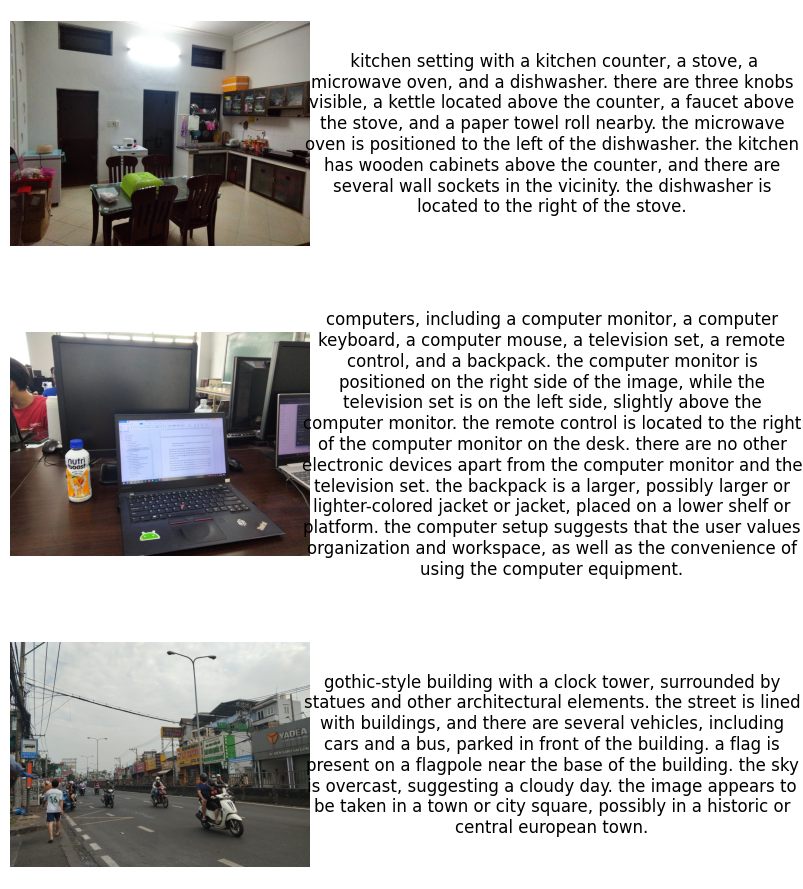

In [20]:
# Danh sách URL ảnh
image_urls = [
    # "http://116.118.50.253:9000/mlflow/user_images/image_20241118052418.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241125104719.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241125081856.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241110014605.jpg",
    # "http://116.118.50.253:9000/mlflow/user_images/image_20241110100519.jpg"
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)